# Load orignial and Ref faces

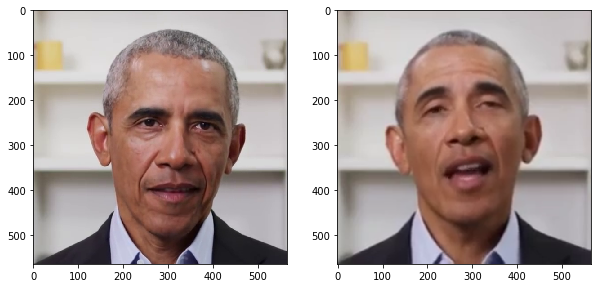

In [1]:
import cv2
import matplotlib.pyplot as plt

img_in = cv2.imread("/home/vuthede/Desktop/3D/31_in.png")
img_ref = cv2.imread("/home/vuthede/Desktop/3D/31_ref.png") 

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(img_in[:,:,::-1])
ax[1].imshow(img_ref[:,:,::-1])

In [2]:
import sys
sys.path.insert(0, "../../PRNet")
from api import PRN
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # cpu
prn = PRN(is_dlib = True, prefix="../../PRNet")

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Please use `layer.__call__` method instead.





INFO:tensorflow:Restoring parameters from ../../PRNet/Data/net-data/256_256_resfcn256_weight


# Show postion map of 2 faces

Here is input:  (565, 565, 3)
Here is input:  (565, 565, 3)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Pose shape:  (256, 256, 3) (256, 256, 3)
Vertices shape:  (43867, 3) (43867, 3)


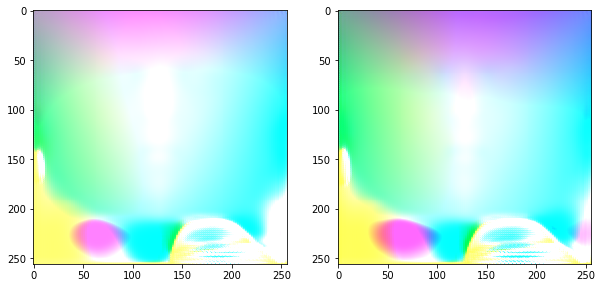

In [223]:
from utils.render import render_texture
from utils.rotate_vertices import frontalize
from utils.estimate_pose import estimate_pose

pos1 = prn.process(img_in) 
vertices1 = prn.get_vertices(pos1)
cam_mat1, pose1, R1 = estimate_pose(vertices1)
pos2 = prn.process(img_ref) 
vertices2 = prn.get_vertices(pos2)
cam_mat2, pose2, R2 = estimate_pose(vertices2)

print("Pose shape: ", pos1.shape, pos2.shape)
print("Vertices shape: ", vertices1.shape, vertices2.shape)

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(pos1.astype(int)[:,:,::-1])
ax[1].imshow(pos2.astype(int)[:,:,::-1])

In [269]:
# New_vertice = Vertice2*R2*invert(R1)
print(f'Shape V2: {vertices2.shape}. R2 shape: {R2.shape}. R1 shape :{R1.shape}')

center1_pt = np.mean(vertices1, axis=0)
vertices1_trans = vertices1 - center1_pt
# center2_pt = np.mean(vertices2, axis=0)
# vertices2_trans = vertices2 - center2_pt

warp_vertices = np.matmul(np.matmul(vertices2,R2), np.linalg.inv(R1)) 
center2_warp_pt = np.mean(warp_vertices, axis=0)
warp_vertices = warp_vertices - (center2_warp_pt - center1_pt)

print("New shape warp vertices: ", warp_vertices.shape)


Shape V2: (43867, 3). R2 shape: (3, 3). R1 shape :(3, 3)
New shape warp vertices:  (43867, 3)


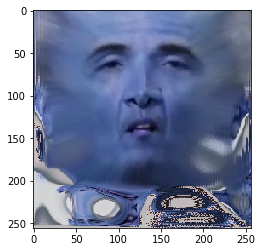

In [283]:
texture_ref = cv2.remap(img_ref/255.0, pos2[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
[h, w, c] = img_ref.shape
color = prn.get_colors_from_texture(texture_ref)
color_mask = np.ones((warp_vertices.shape[0], 1))
new_image = render_texture(warp_vertices.T, color.T, prn.triangles.T, h, w, c = 3)
facemask = render_texture(warp_vertices.T, color_mask.T, prn.triangles.T, h, w, c = 3)

plt.imshow(texture_ref)

Text(0.5, 1.0, 'Output')

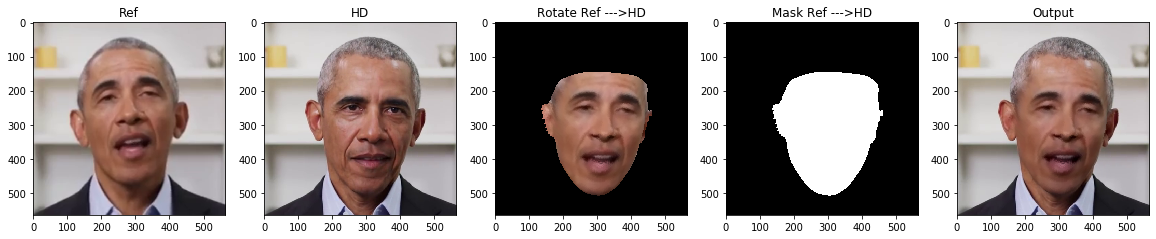

In [288]:
fig, ax = plt.subplots(1,5,figsize=(20,5))

vis_ind = np.argwhere(facemask>0)
vis_min = np.min(vis_ind, 0)
vis_max = np.max(vis_ind, 0)
center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
output = cv2.seamlessClone((new_image*255).astype(np.uint8), (img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)

ax[1].imshow(img_in[:,:,::-1])
ax[1].set_title("HD")
ax[0].imshow(img_ref[:,:,::-1])
ax[0].set_title("Ref")
ax[2].imshow(new_image[:,:,::-1])
ax[2].set_title("Rotate Ref --->HD")
ax[3].imshow(facemask)
ax[3].set_title("Mask Ref --->HD")
ax[4].imshow(output[:,:,::-1])
ax[4].set_title("Output")

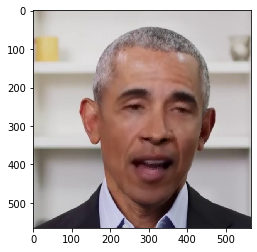

In [286]:
vis_ind = np.argwhere(facemask>0)
vis_min = np.min(vis_ind, 0)
vis_max = np.max(vis_ind, 0)
center = (int((vis_min[1] + vis_max[1])/2+0.5), int((vis_min[0] + vis_max[0])/2+0.5))
output = cv2.seamlessClone((new_image*255).astype(np.uint8), (img_in).astype(np.uint8), (facemask*255).astype(np.uint8), center, cv2.NORMAL_CLONE)
plt.imshow(output[:,:,::-1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(256, 256, 3)


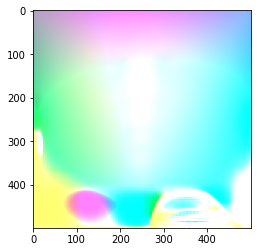

In [64]:
a = pos1
print(a.shape)
pos11 = cv2.resize(a, (500,500))
plt.imshow(pos11[:,:,::-1].astype(int))

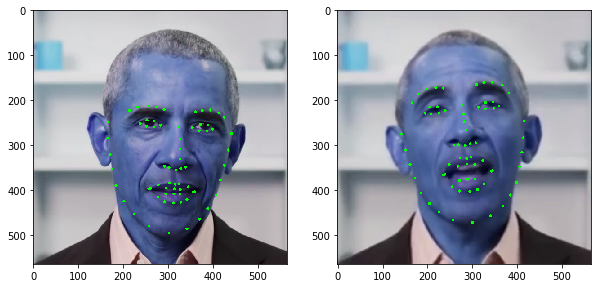

In [4]:
def draw_landmark(im, l, color =(0,255,0)):
    im_ = im.copy()
    for i in l:
        cv2.circle(im_, (int(i[0]),int(i[1])), 3,color, -1)

    return im_
    
lmk_in = prn.get_landmarks(pos1)
lmk_ref = prn.get_landmarks(pos2)

ig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(draw_landmark(img_in, lmk_in))
ax[1].imshow(draw_landmark(img_ref, lmk_ref))


In [10]:
from utils.estimate_pose import estimate_pose

camera_matrix1, pose1, rotation_matrix1 = estimate_pose(vertices1)
camera_matrix2, pose2, rotation_matrix2 = estimate_pose(vertices2)
print(f"Pose1:\n {pose1}. \nPose2:\n {pose2}\n")
print(f"Rotation matrix 1:\n {rotation_matrix1}. \nRotatation matrix 2:\n {rotation_matrix2}")


Pose1:
 (-0.12431485583644954, -0.11209803114451622, 0.07614010521109965). 
Pose2:
 (-0.01098619651278795, 0.1147032416291169, -0.09681911258700034)

Rotation matrix 1:
 [[ 0.98940796 -0.08941944  0.11435061]
 [ 0.07547954  0.98978944  0.12091198]
 [-0.12399491 -0.11100014  0.98605488]]. 
Rotatation matrix 2:
 [[ 9.95256625e-01  9.72841727e-02 -2.01154001e-04]
 [-9.66620870e-02  9.88654711e-01 -1.14970884e-01]
 [-1.09859755e-02  1.14444978e-01  9.93368842e-01]]


# Align In and Ref image

In [16]:
import sys
sys.path.insert(0, "../../deepfeatinterp")
import alignface

M,loss=alignface.fit_face_landmarks(lmk_in[:,:2],lmk_ref[:,:2], image_dims=img_in.shape[:2])
print(M)

[[  1.01443162   0.17233784 -92.67427724]
 [ -0.17815207   1.0486559    0.31474338]]


In [72]:
# four_lmks_ind = [30,3,8,13]
# print(lmk_ref[four_lmks_ind])
# cv2.getPerspectiveTransform(lmk_ref[four_lmks_ind], lmk_in[four_lmks_ind])

In [ ]:
# img_ref_warp = cv2.warpPerspective(img_ref, rotation_matrix2, img_in.shape[:2])

# fig, ax = plt.subplots(1,2, figsize=(10,5))
# ax[0].imshow(img_ref)
# ax[1].imshow(img_ref_warp)

# Rigid transformation

In [215]:
from numpy import *
from math import sqrt
import numpy as np

def rigid_transform_3D(A, B):
    assert len(A) == len(B)

    num_rows, num_cols = A.shape

    # if num_rows != 3:
    #     raise Exception("matrix A is not 3xN, it is {}x{}".format(num_rows, num_cols))

    # [num_rows, num_cols] = B.shape
    # if num_rows != 3:
    #     raise Exception("matrix B is not 3xN, it is {}x{}".format(num_rows, num_cols))

    # find mean column wise
    centroid_A = mean(A, axis=1)
    centroid_B = mean(B, axis=1)

    # ensure centroids are 3x1 (necessary when A or B are 
    # numpy arrays instead of numpy matrices)
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - tile(centroid_A, (1, num_cols))
    Bm = B - tile(centroid_B, (1, num_cols))

    H = np.matmul(Am ,transpose(Bm))
    

    # find rotation
    U, S, Vt = linalg.svd(H)
    R = np.matmul(Vt.T,U.T)

    # special reflection case
    if linalg.det(R) < 0:
        print("det(R) < R, reflection detected!, correcting for it ...\n")
        Vt[2,:] *= -1
        R = np.matmul(Vt.T, U.T)

    t = np.matmul(-R,centroid_A) + centroid_B

    return R, t



Shape lmk ref:(68, 3). Shape in (68, 3)
Rotation matrix:
  [[ 0.97755434 -0.19027657  0.09045628]
 [ 0.16715617  0.96181115  0.21674439]
 [-0.12824324 -0.19675909  0.97202857]]
Translation matrix:
 [[ 73.64442988]
 [-44.07504231]
 [114.89476411]]


Shape lmk ref:(68, 3). Shape in (68, 3)
Rotation matrix:
  [[ 0.97755434 -0.19027657  0.09045628]
 [ 0.16715617  0.96181115  0.21674439]
 [-0.12824324 -0.19675909  0.97202857]]
Translation matrix:
 [[ 73.64442988]
 [-44.07504231]
 [114.89476411]]


Text(0.5, 1.0, 'Warp kps Ref--->HD 3D')

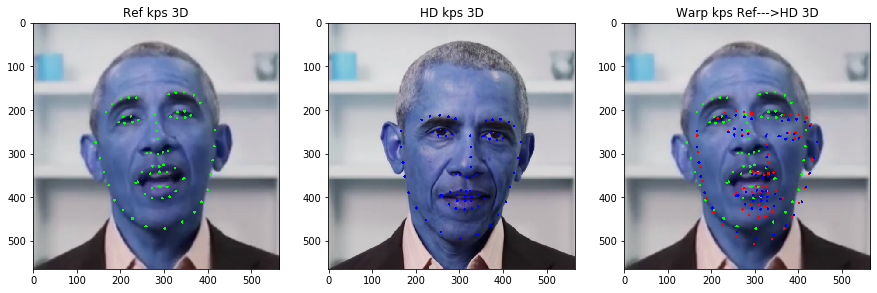

In [219]:
# Calculate rotation and translation matrix
R, t = rigid_transform_3D(lmk_ref.T, lmk_in.T)
print(f"Shape lmk ref:{lmk_ref.shape}. Shape in {lmk_in.shape}")
print("Rotation matrix:\n ", R)
print("Translation matrix:\n", t)

# Rotation and translation
a = np.matmul(R, lmk_ref.T).T + t.T

# Plot
a = np.array(a).astype(int)
ig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(draw_landmark(img_ref, lmk_ref, (0,255,0)))
ax[1].imshow(draw_landmark(img_in, lmk_in,(0,0,255)))
draw = draw_landmark(draw_landmark(draw_landmark(img_ref, lmk_ref, (0,255,0)), a,(255,0,0)), lmk_in, (0,0,255))
ax[2].imshow(draw)
ax[0].set_title("Ref kps 3D")
ax[1].set_title("HD kps 3D")
ax[2].set_title("Warp kps Ref--->HD 3D")


Text(0.5, 1.0, 'Warp kps Ref--->HD 2D')

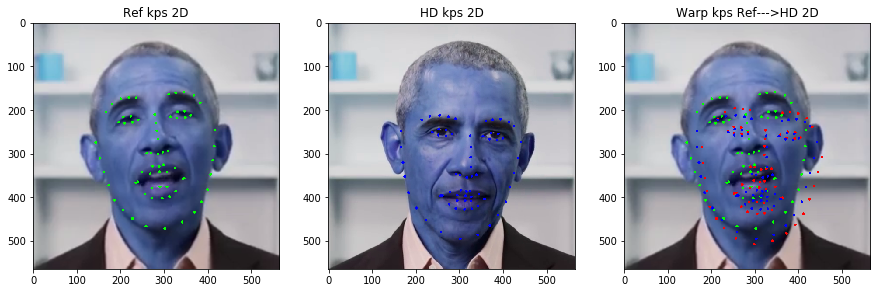

In [220]:
ind = list(range(68))
R, t = rigid_transform_3D(lmk_ref[:,:2].T, lmk_in[:,:2].T)

# 
a = np.matmul(R, lmk_ref[:,:2].T).T + t.T

# Plot
a = np.array(a).astype(int)
fig, ax = plt.subplots(1,3, figsize=(15,10))
ax[0].imshow(draw_landmark(img_ref, lmk_ref, (0,255,0)))
ax[1].imshow(draw_landmark(img_in, lmk_in,(0,0,255)))
draw = draw_landmark(draw_landmark(draw_landmark(img_ref, lmk_ref, (0,255,0)), a,(255,0,0)), lmk_in, (0,0,255))
ax[2].imshow(draw)
ax[0].set_title("Ref kps 2D")
ax[1].set_title("HD kps 2D")
ax[2].set_title("Warp kps Ref--->HD 2D")

In [209]:
lmk_in.shape
lmk_ref.shape


(68, 3)

In [103]:
R = mat(random.rand(3,3))
t = mat(random.rand(3,1))


# make R a proper rotation matrix, force orthonormal
U, S, Vt = linalg.svd(R)
R = U*Vt

# remove reflection
if linalg.det(R) < 0:
   Vt[2,:] *= -1
   R = U*Vt

# number of points
n = 10

# A = mat(random.rand(3, n));
A = array(random.rand(3, n))
B = R*A + tile(t, (1, n))
print(type(a))
print(B.shape)
ret_R, ret_t = rigid_transform_3D(A, B)

print(ret_R.shape)
print(ret_t.shape)
print(A.shape)

# B2 = (ret_R*A) + tile(ret_t, (1, n))

<class 'numpy.ndarray'>
(3, 10)
(3, 3)
(3, 1)
(3, 10)


In [45]:
# img_ref_warp = cv2.remap(img_ref)

# fig, ax = plt.subplots(1,2, figsize=(10,5))
# ax[0].imshow(img_ref)
# ax[1].imshow(img_ref_warp)

TypeError: Expected Ptr<cv::UMat> for argument 'M'

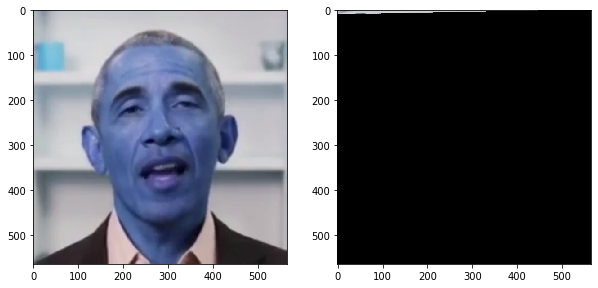

In [20]:
img_ref_warp = cv2.warpPerspective(img_ref, rotation_matrix2, img_in.shape[:2])

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(img_ref)
ax[1].imshow(img_ref_warp)

In [52]:
import numpy as np
np.meshgrid(np.linspace(0,10,11), np.linspace(0,5,6))

[array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
        [4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
        [5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.]])]